In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define column names based on the user's description
column_names = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']

In [12]:
# Step analysis 

trans2_step_data = pd.read_csv('trans_step_data.csv', header=None, names=column_names)

# Assuming each row corresponds to 1/50th of a second, create a time column for the first dataset
trans2_step_data['Time'] = trans2_step_data.index / 50  # Dataset was collected at 50 Hz
trans2_step_data_filtered = trans2_step_data[trans2_step_data['Time'] <= 20]

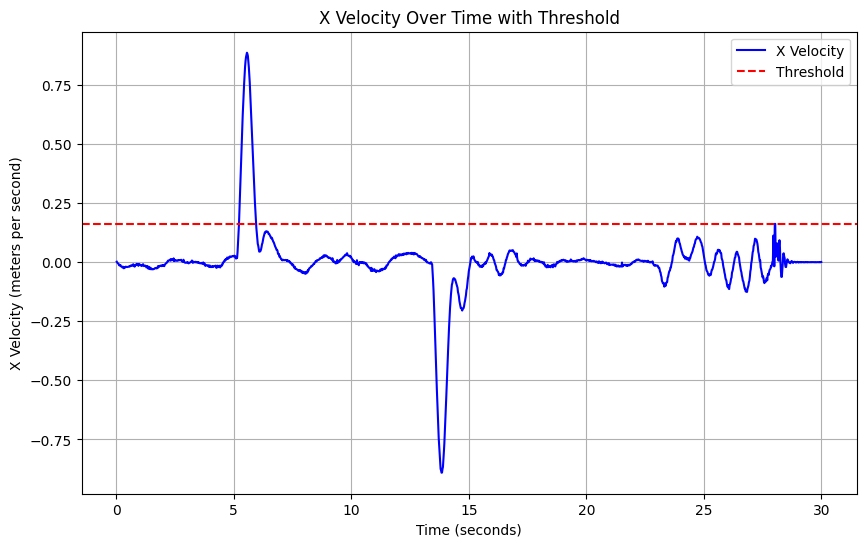

(0.15999999999999998, 4)

In [15]:
# Adjusting the approach to account for the nature of the step responses as curves
# This time, we aim for more than 10 intersections as a stop condition, indicating we've captured the 5 step inputs

# Reinitialize the starting threshold and conditions
threshold = 0.2
threshold_decrement = 0.005
intersections_found = 0
trans2_step_data['X_derivative'] = trans2_step_data['X'].diff() / trans2_step_data['Time'].diff()
trans2_step_data_filtered = trans2_step_data[trans2_step_data['Time'] <= 30]


# Reset analysis to start with the highest threshold and move downwards
while threshold > 0:
    # Count the number of times the derivative crosses the threshold, indicating intersections
    # This is done by checking where the derivative goes from below to above the threshold or vice versa
    crosses_threshold = ((trans2_step_data_filtered['X_derivative'] > threshold) & 
                         (trans2_step_data_filtered['X_derivative'].shift(1) < threshold)) | \
                        ((trans2_step_data_filtered['X_derivative'] < threshold) & 
                         (trans2_step_data_filtered['X_derivative'].shift(1) > threshold))
    
    intersections_found = crosses_threshold.sum()
    
    # Stop condition: If more than 10 intersections, we likely have captured the 5 steps
    if intersections_found > 2:
        break
    else:
        # If not, decrease the threshold and try again
        threshold -= threshold_decrement

# Plot the derivative with the final threshold line to visualize the intersections
plt.figure(figsize=(10, 6))
plt.plot(trans2_step_data_filtered['Time'], trans2_step_data_filtered['X_derivative'], label='X Velocity', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('X Velocity Over Time with Threshold')
plt.xlabel('Time (seconds)')
plt.ylabel('X Velocity (meters per second)')
plt.grid(True)
plt.legend()
plt.show()

threshold, intersections_found

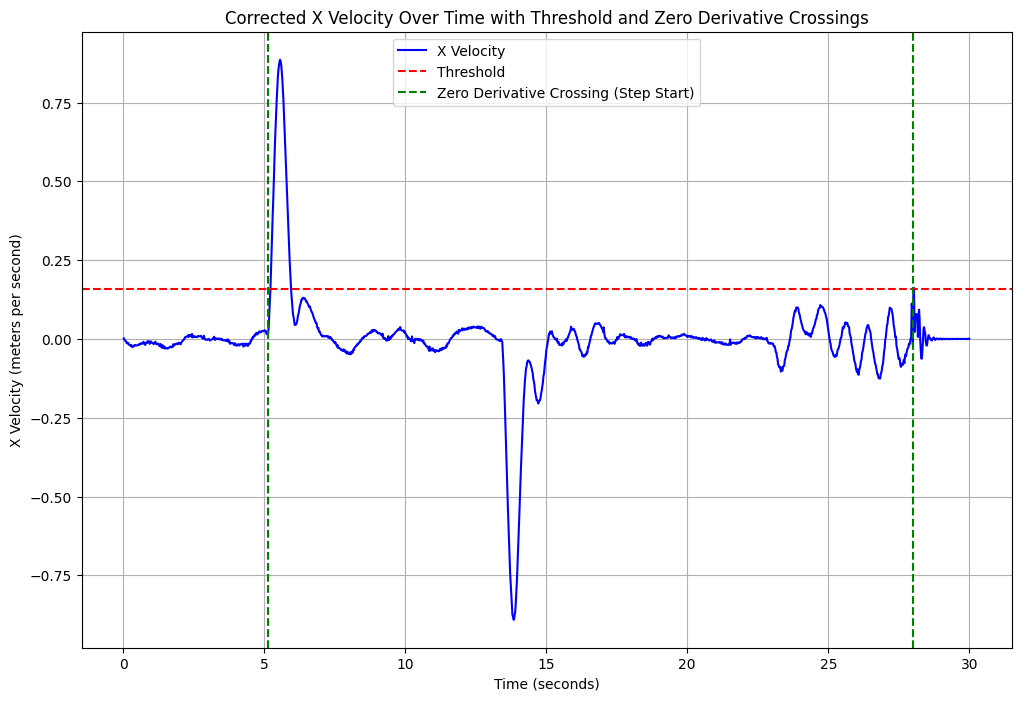

[5.14, 28.02]

In [19]:
# Correcting the approach based on the new explanation
# Starting at each threshold crossing point, move back in time until the derivative crosses zero
cross_points = trans2_step_data_filtered[crosses_threshold]['Time']
# Initialize a list to store the corrected time points for when the derivative first crosses zero moving back from each threshold point
corrected_zero_derivative_times = []

for cross_time in cross_points:
    # Filter the dataset to consider only points before the current crossing point
    before_cross = trans2_step_data_filtered[trans2_step_data_filtered['Time'] <= cross_time]
    
    # Find the first point moving back in time where the derivative crosses zero
    zero_crossings = before_cross[before_cross['X_derivative'] * before_cross['X_derivative'].shift(1) < 0.0005]
    
    if not zero_crossings.empty:
        zero_derivative_time = zero_crossings.iloc[-1]['Time']  # The last crossing point before the threshold crossing
        corrected_zero_derivative_times.append(zero_derivative_time)

# Remove potential duplicates due to very close zero crossings by converting to set and back to list
corrected_zero_derivative_times = list(set(corrected_zero_derivative_times))

# Sort the list to maintain chronological order
corrected_zero_derivative_times.sort()

# Plot the derivative graph again, this time highlighting the corrected zero derivative points
plt.figure(figsize=(12, 8))
plt.plot(trans2_step_data_filtered['Time'], trans2_step_data_filtered['X_derivative'], label='X Velocity', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# Highlight corrected zero derivative points
for zero_time in corrected_zero_derivative_times:
    plt.axvline(x=zero_time, color='green', linestyle='--', label='Zero Derivative Crossing (Step Start)' if corrected_zero_derivative_times.index(zero_time) == 0 else "")

plt.title('Corrected X Velocity Over Time with Threshold and Zero Derivative Crossings')
plt.xlabel('Time (seconds)')
plt.ylabel('X Velocity (meters per second)')
plt.grid(True)
plt.legend()
plt.show()

corrected_zero_derivative_times


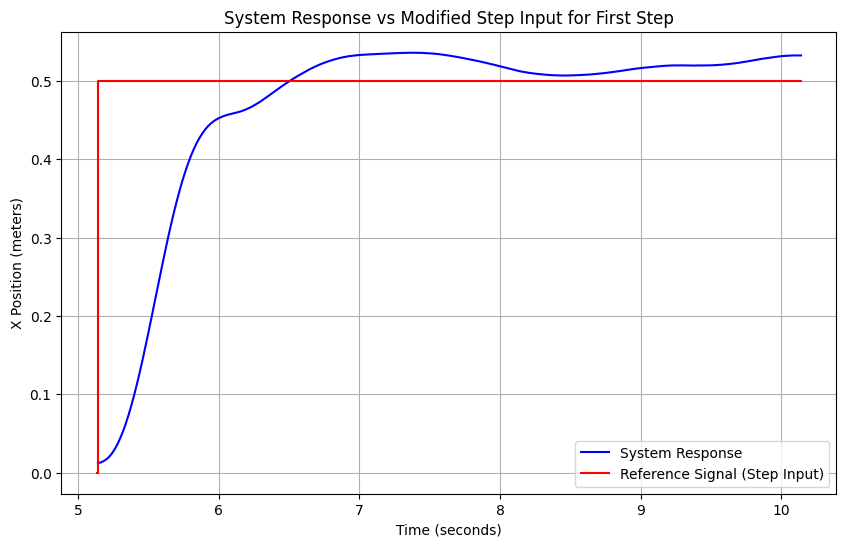

In [21]:
# For the very first step command, we use the first starting time from the list
first_step_time = 5.14

# Determine the observation duration based on the interval until the next step command
# This time, we'll ensure the reference signal remains at 0.25 m without dropping back down to 0
observation_duration = 5

# Define the start and end times for plotting
plot_start_time = first_step_time
plot_end_time = first_step_time + observation_duration

# Filter the dataset for the time period of interest for plotting
plot_data = trans2_step_data[(trans2_step_data['Time'] >= plot_start_time) & (trans2_step_data['Time'] <= plot_end_time)]

# Adjust the reference signal for the step input, creating a sideways L shape
ref_signal_time = [plot_start_time, plot_end_time]
ref_signal_x = [0.25, 0.25]  # Maintain at 0.25 meters

ref_signal_time_modified = [plot_start_time-0.01, plot_start_time, plot_end_time]  # Adding a small offset for the vertical line
ref_signal_x_modified = [0, 0.5, 0.5]  # Initial rise from 0 to 0.25 meters

# Re-plot the first step input's positional data along with the modified reference input
plt.figure(figsize=(10, 6))
plt.plot(plot_data['Time'], plot_data['X'], label='System Response', color='blue')
plt.step(ref_signal_time_modified, ref_signal_x_modified, label='Reference Signal (Step Input)', color='red', where='post')
plt.title('System Response vs Modified Step Input for First Step')
plt.xlabel('Time (seconds)')
plt.ylabel('X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
column_names = ['Common Time']
combined_data = pd.DataFrame(columns=column_names)
step_start_time = first_step_time
time_offset = 0.01

trial_data = trans2_step_data[(trans2_step_data['Time'] >= step_start_time) & 
                                  (trans2_step_data['Time'] <= step_start_time + observation_duration)]
trial_data_adjusted = trial_data.copy()
trial_data_adjusted['Common Time'] = trial_data['Time'] - step_start_time + time_offset